This project aims to leverage toy examples to illustrate how to build linear model, deep neural networks, convolutional nueral networds as well as recurrent neural networks by [Tensorflow](www.tensorflow.org). The dataset is famous handwritten digits dataset, namely [MNIST](http://yann.lecun.com/exdb/mnist/).

In [1]:
#Import required packages
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
#Load MNIST dataset
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
print(mnist.train.images.shape)

(55000, 784)


In [3]:
print(mnist.test.images.shape)

(10000, 784)


There are 55000 items of training data, and 10000 items of testing data. Let's take a look at the samples

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


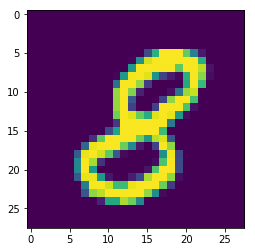

In [4]:
plt.imshow(mnist.train.images[5].reshape([28, 28]))
print(mnist.train.labels[5])

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


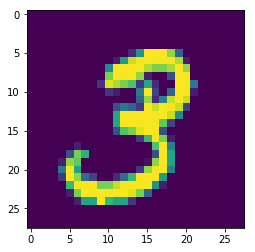

In [5]:
plt.imshow(mnist.train.images[1].reshape([28, 28]))
print(mnist.train.labels[1])

In [6]:
n_tr = mnist.train.images.shape[0]# number of training samples
n_ts = mnist.test.images.shape[0]#number of testing samples
n_pixel = mnist.train.images.shape[1]

## Linear Model

Here's an simple linear model to do classification on MNIST.

In [32]:
#Create a linear graph, define its architecture in terms of nodes and compuatations
graph_linear = tf.Graph()
with graph_linear.as_default():
    #Define input placeholder and target placeholder
    x = tf.placeholder(tf.float32, [None, 784], name='x_placeholder')
    y_ = tf.placeholder(tf.float32, [None,10], name='y_placeholder')
    #Define a linear model structure
    def linearModel(x):
        #Create weights and biases
        W = tf.Variable(tf.zeros([784,10]), name='weights')
        b = tf.Variable(tf.zeros([10]), name='biases')
        #Softmax output 
        y = tf.nn.softmax(tf.matmul(x,W) + b)
        return y
    y = linearModel(x)
    #Cross entropy as the loss
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    #Use gradient descent method to optmize
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [33]:
e_pochs = 10
batch_size = 64
num_steps = int(n_tr/batch_size)
#Create a session, in order to run the graph
with tf.Session(graph=graph_linear) as sess:
    #Initialize all the variables created above
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for _ in range(e_pochs):
        for step in range(num_steps):
            #offset = (step * batch_size) % (mnist.train.labels.shape[0] - batch_size)
            #Feed the dataset to the placeholders     
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            #batch_data = mnist.train.images[offset:(offset + batch_size), :]
            #batch_labels = mnist.train.labels[offset:(offset + batch_size), :]
            #Pass the data to a dictionary
            feed_dict = {x : batch_data, y_ : batch_labels}
            #Train the model by feeding batch data
            _, loss = sess.run([train_step, cross_entropy], feed_dict=feed_dict)
            #Calculate acccuracy after 500 times training
            if step%500 == 0:
                result = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
                print("Test Accuracy：", result)

Test Accuracy： 0.3195
Test Accuracy： 0.9114
Test Accuracy： 0.9193
Test Accuracy： 0.9178
Test Accuracy： 0.9209
Test Accuracy： 0.9116
Test Accuracy： 0.9121
Test Accuracy： 0.9087
Test Accuracy： 0.9194
Test Accuracy： 0.9096
Test Accuracy： 0.9225
Test Accuracy： 0.9206
Test Accuracy： 0.9231
Test Accuracy： 0.9219
Test Accuracy： 0.9223
Test Accuracy： 0.9164
Test Accuracy： 0.9174
Test Accuracy： 0.9161
Test Accuracy： 0.9257
Test Accuracy： 0.9118


## Fully Connected Model

This example uses several fully connected neural network layers to train the classification.

In [34]:
#Created a fully connected graph
graph_fully = tf.Graph()
with graph_fully.as_default() as g:
    #Define input placeholders
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None,10])
    num_class = y.shape[1].value
    num_pixel = x.shape[1].value
    #Define the architecture of neural networks
    def multiHiddenLayer(x, layers):
        num_layer = len(layers)
        pre_units = num_pixel#输入节点
        next_units = pre_units#输出节点
        data = x
        #Traverse each layer
        for i in range(num_layer):            
            with g.name_scope('hidden'+str(i)):
                #权重
                next_units = layers[i]
                weights = tf.Variable(
                    tf.truncated_normal([pre_units, next_units],
                                        stddev=1.0 / np.sqrt(float(pre_units))),
                    name='weights')
                #偏差
                biases = tf.Variable(tf.zeros([next_units]), 
                                     name='biases')
                hidden = tf.nn.relu(tf.matmul(data, weights) + biases)
                data = hidden
                pre_units = next_units
        # Linear
        with g.name_scope('softmax_linear'):
            weights = tf.Variable(
                tf.truncated_normal([next_units, num_class],
                                    stddev=1.0 / np.sqrt(float(next_units))),
                name='weights')
            biases = tf.Variable(tf.zeros([num_class]),
                                 name='biases')
            logits = tf.matmul(data, weights) + biases
        return tf.nn.softmax(logits)

In [35]:
with graph_fully.as_default() as g:
    layers = [128, 64]#neurons for each layer
    y = multiHiddenLayer(x, layers)
    #定义目标函数，采用交叉熵
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    #定义训练方式，梯度下降法
    train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)
    #定义模型评价指标精确度
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [36]:
e_pochs = 20
batch_size = 64
num_steps = int(n_tr/batch_size)
#Create a session
with tf.Session(graph=graph_fully) as sess:
    #Initialize all the variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for _ in range(e_pochs):
        for step in range(num_steps):
            #offset = (step * batch_size) % (mnist.train.labels.shape[0] - batch_size)
            #Feed the dataset to the placeholders     
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            #Pass the data to a dictionary
            feed_dict = {x : batch_data, y_ : batch_labels}
            #Train the model by feeding batch data
            _, loss = sess.run([train_step, cross_entropy], feed_dict=feed_dict)
            #Calculate acccuracy after 500 times training
            if step%500 == 0:
                result = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
                print("Test Accuracy：", result)

Test Accuracy： 0.1208
Test Accuracy： 0.9107
Test Accuracy： 0.9245
Test Accuracy： 0.9379
Test Accuracy： 0.9456
Test Accuracy： 0.9526
Test Accuracy： 0.9559
Test Accuracy： 0.9596
Test Accuracy： 0.9627
Test Accuracy： 0.9644
Test Accuracy： 0.9671
Test Accuracy： 0.9684
Test Accuracy： 0.964
Test Accuracy： 0.9685
Test Accuracy： 0.9711
Test Accuracy： 0.9729
Test Accuracy： 0.9727
Test Accuracy： 0.9749
Test Accuracy： 0.9724
Test Accuracy： 0.9735
Test Accuracy： 0.9756
Test Accuracy： 0.9726
Test Accuracy： 0.9747
Test Accuracy： 0.9749
Test Accuracy： 0.9774
Test Accuracy： 0.9761
Test Accuracy： 0.9765
Test Accuracy： 0.9774
Test Accuracy： 0.9735
Test Accuracy： 0.9744
Test Accuracy： 0.9772
Test Accuracy： 0.9764
Test Accuracy： 0.9759
Test Accuracy： 0.9772
Test Accuracy： 0.9766
Test Accuracy： 0.9763
Test Accuracy： 0.9767
Test Accuracy： 0.9764
Test Accuracy： 0.9776
Test Accuracy： 0.9792


## Convolutional Neural Network

Following example shows how to create a convolutional neural network. In addition, 'name_scope' is taken into consideration for each layer. Reference:http://wiki.jikexueyuan.com/project/tensorflow-zh/how_tos/variable_scope.html

In [7]:
#Create weights
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name='weights')

#Create biases
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name='biases')

In [8]:
#Convolutional function
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
#Max pool function
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [9]:
def conv_relu_pool(input, kernel_shape, bias_shape):
    # Create variable named "weights".
    weights = weight_variable(kernel_shape)
    # Create variable named "biases".
    biases = bias_variable(bias_shape)
    conv = conv2d(input, weights)
    relu = tf.nn.relu(conv + biases)
    pool = max_pool_2x2(relu)
    return pool

In [10]:
def cnnLayer(x, keep_prob):
    x_image = tf.reshape(x, [-1,28,28,1])
    #First Conv
    with tf.name_scope('hidden1'):
        kernel_shape, bias_shape = [5, 5, 1, 32], [32] 
        h_pool1 = conv_relu_pool(x_image, kernel_shape, bias_shape)
        
    #Second Conv
    with tf.name_scope('hidden2'):
        kernel_shape, bias_shape = [5, 5, 32, 64], [64] 
        h_pool2 = conv_relu_pool(h_pool1, kernel_shape, bias_shape)
    
    #Fully Connected Layer
    with tf.name_scope('fully_connected'):
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        #Dropout, to prevent against overfitting      
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    #Softmax Layer
    with tf.name_scope('softmax_layer'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    return tf.nn.softmax(logits)

In [11]:
graph_cnn = tf.Graph()
with graph_cnn.as_default() as g:
    #Create input placeholders
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None,10])
    #Define ropout probability placholder
    keep_prob = tf.placeholder("float")   

    y = cnnLayer(x, keep_prob)
    #Define cross-entropy as loss function
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    #Adam Optimizer
    train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy)
    #Define accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [12]:
e_pochs = 10
batch_size = 64
num_steps = int(n_tr/batch_size)
#Create a session
with tf.Session(graph=graph_cnn) as sess:
    #Initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for _ in range(e_pochs):
        for step in range(num_steps):
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 0.5}
            #Train
            _, loss = sess.run([train_step, cross_entropy], feed_dict=feed_dict)
            if step%500 == 0:
                print('Loss:', loss)
                
    count = 0    
    for _ in range(200):
        batch_data, batch_labels = mnist.test.next_batch(50)
        feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
        cp = sess.run(correct_prediction, feed_dict=feed_dict)
        count += np.sum(cp)
    print("Testing Accuracy：", count/n_ts)

Loss: 847.828
Loss: 17.2792
Loss: 6.03226
Loss: 8.99566
Loss: 0.492449
Loss: 1.18727
Loss: 0.539927
Loss: 3.20441
Loss: 4.73405
Loss: 0.0628569
Loss: 0.541013
Loss: 5.22627
Loss: 0.867604
Loss: 2.71618
Loss: 0.466885
Loss: 0.0806042
Loss: 0.0407576
Loss: 5.98011
Loss: 1.28675
Loss: 0.0196769
Testing Accuracy： 0.9925


## CNN With Improvement

In order to improve the performance of CNN, we can replace normal initialization with Xavier initialization, which is said to be more effective, in addition a declining learning rate is adopted rather than a constant one as the more close to the optimal value the smaller we expect the rate to be.

In [13]:
initializer = tf.contrib.layers.xavier_initializer_conv2d()
#Create weights
def weight_variable(shape):
  #initial = tf.truncated_normal(shape, stddev=0.01)
  return tf.Variable(initializer(shape), name='weights')

#Create biases
def bias_variable(shape):
  #initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initializer(shape), name='biases')

#Convolutional function
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
#Max pool function
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [14]:
def cnnLayer2(x, keep_prob):
    x_image = tf.reshape(x, [-1,28,28,1])
    #First Conv
    with tf.name_scope('hidden1'):
        kernel_shape, bias_shape = [3, 3, 1, 32], [32] 
        h_pool1 = conv_relu_pool(x_image, kernel_shape, bias_shape)
        
    #Second Conv
    with tf.name_scope('hidden2'):
        kernel_shape, bias_shape = [3, 3, 32, 64], [64] 
        h_pool2 = conv_relu_pool(h_pool1, kernel_shape, bias_shape)
    
    #Fully Connected Layer
    with tf.name_scope('fully_connected'):
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        #Dropout, to prevent against overfitting      
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    #Softmax Layer
    with tf.name_scope('softmax_layer'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    return tf.nn.softmax(logits)

Note, here we use a declining learning rate for gradient descending method.

In [15]:
graph_cnn2 = tf.Graph()
with graph_cnn2.as_default() as g:
    #Create input placeholders
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None,10])
    #Define ropout probability placholder
    keep_prob = tf.placeholder("float")   

    y = cnnLayer2(x, keep_prob)
    #Define cross-entropy as loss function
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    #Gradient Descending Optimizer
    cur_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
    starter_learning_rate = 0.0005
    learning_rate = tf.train.exponential_decay(starter_learning_rate, cur_step, 500, 0.96, staircase=True)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy, global_step=cur_step)
    #train_step = tf.train.AdamOptimizer(0.00001).minimize(cross_entropy)
    #Define accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [17]:
e_pochs = 30
batch_size = 64
num_steps = int(n_tr/batch_size)
#Create a session
with tf.Session(graph=graph_cnn2) as sess:
    #Initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    #Run on GTX960 GPU
    for _ in range(e_pochs):
        for step in range(num_steps):
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 0.5}
            #Train
            _, loss = sess.run([train_step, cross_entropy], feed_dict=feed_dict)
            if step%500 == 0:
                feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
                loss = sess.run(cross_entropy, feed_dict=feed_dict)
                print('Loss:', loss)
                
    count = 0  
    #Due to the limited GPU memory, we have to split the testing data into batches
    for _ in range(200):
        batch_data, batch_labels = mnist.train.next_batch(50)
        feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
        cp = sess.run(correct_prediction, feed_dict=feed_dict)
        count += np.sum(cp)
    print("Testing Accuracy：", count/n_ts)

Loss: 147.909
Loss: 5.70927
Loss: 4.90338
Loss: 4.17822
Loss: 1.32107
Loss: 3.26418
Loss: 4.67591
Loss: 6.36736
Loss: 0.97047
Loss: 1.15154
Loss: 0.919087
Loss: 1.29124
Loss: 1.96115
Loss: 0.6948
Loss: 0.628241
Loss: 0.858873
Loss: 0.56969
Loss: 1.07278
Loss: 4.25916
Loss: 0.324269
Loss: 1.46772
Loss: 0.54338
Loss: 0.353937
Loss: 0.255792
Loss: 0.544565
Loss: 0.198912
Loss: 0.811475
Loss: 0.103436
Loss: 0.847413
Loss: 16.1115
Loss: 0.317075
Loss: 0.371413
Loss: 0.409622
Loss: 0.32419
Loss: 0.695689
Loss: 0.150755
Loss: 0.111508
Loss: 1.06223
Loss: 0.134771
Loss: 0.667687
Loss: 0.64333
Loss: 1.4673
Loss: 0.0713766
Loss: 0.479754
Loss: 0.694741
Loss: 0.147707
Loss: 0.175523
Loss: 0.478875
Loss: 0.561402
Loss: 0.480085
Loss: 0.596364
Loss: 2.10838
Loss: 0.390726
Loss: 0.601686
Loss: 0.722839
Loss: 2.27915
Loss: 0.153502
Loss: 0.242326
Loss: 0.461885
Loss: 0.196564
Testing Accuracy： 0.9983


## Recurrent Neural Network

In [12]:
from tensorflow.contrib import rnn
# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)
learning_rate = 0.00002

In [132]:
def rnnLayer(x):
    '''
    Create a Rnn layer
    Treat each image as a series of vectors
    the time step is n_step
    the size of input vector is n_input
    '''
    # Transform X into series
    # Reshape data to get 28 seq of 28 elements
    x = tf.reshape(x, (-1, n_steps, n_input))
    x = tf.transpose(x, [1, 0, 2])
    # (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # (batch_size, n_input)
    x = tf.split(x, n_steps, 0)
    with tf.variable_scope("rnn_lstm"):
        # Define a lstm cell with tensorflow
        lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
        with tf.variable_scope('rnn_layer'):
            # Get lstm cell output
            outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
            # Linear activation, using rnn inner loop last output
        with tf.name_scope('fully_connected'):
            # FUlly Connected layer
            weights = tf.Variable(tf.random_normal([n_hidden, n_classes]), name='weights')
            biases = tf.Variable(tf.random_normal([n_classes]), name='biases')
    logits = tf.matmul(outputs[-1], weights) + biases
    return tf.nn.softmax(logits)

In [137]:
graph_rnn = tf.Graph()
with graph_rnn.as_default():
    # tf Graph input
    x = tf.placeholder(tf.float32, [None, n_steps*n_input])
    y_ = tf.placeholder(tf.float32, [None, n_classes])
    y = rnnLayer(x)
    # Define loss and optimizer
    cross_entropy = -tf.reduce_mean(y_* tf.log(y))
    
    cur_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
    starter_learning_rate = 0.005
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(cross_entropy, tvars),
                                      5)
    #optimizer = tf.train.GradientDescentOptimizer(cur_step)
    #learning_rate = tf.train.exponential_decay(starter_learning_rate, cur_step, 1000, 0.96, staircase=True)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #train_op = optimizer.apply_gradients(
        #zip(grads, tvars),
        #global_step=cur_step)
    optimizer = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(y_,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



In [139]:
# Parameters
e_pochs = 20
batch_size = 64
num_steps = int(n_tr/batch_size)
display_step = 600
# Launch the graph
with tf.Session(graph=graph_rnn) as sess:
    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)
    # Keep training until reach max iterations
    for _ in range(e_pochs):
        for step in np.arange(num_steps):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
        
             # Run optimization op (backprop)
            _, loss, acc = sess.run([optimizer, cross_entropy, accuracy], feed_dict={x: batch_x, y_: batch_y})
            if step % display_step == 0:
                # Calculate batch accuracy
                print('Loss:{:.5f}'.format(loss), "Training Accuracy= " + \
                      "{:.5f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_data = mnist.test.images
    test_label = mnist.test.labels
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y_: test_label}))

Loss:0.26374 Training Accuracy= 0.09375
Loss:0.05619 Training Accuracy= 0.81250
Loss:0.05009 Training Accuracy= 0.84375
Loss:0.03332 Training Accuracy= 0.92188
Loss:0.01795 Training Accuracy= 0.93750
Loss:0.02159 Training Accuracy= 0.95312
Loss:0.01759 Training Accuracy= 0.95312
Loss:0.01550 Training Accuracy= 0.93750
Loss:0.01899 Training Accuracy= 0.92188
Loss:0.00603 Training Accuracy= 0.98438
Loss:0.00750 Training Accuracy= 0.98438
Loss:0.01236 Training Accuracy= 0.96875
Loss:0.00897 Training Accuracy= 0.98438
Loss:0.01271 Training Accuracy= 0.93750
Loss:0.00758 Training Accuracy= 0.98438
Loss:0.00407 Training Accuracy= 0.98438
Loss:0.00391 Training Accuracy= 0.98438
Loss:0.00368 Training Accuracy= 1.00000
Loss:0.00607 Training Accuracy= 0.98438
Loss:0.01294 Training Accuracy= 0.96875
Loss:0.01248 Training Accuracy= 0.96875
Loss:0.01447 Training Accuracy= 0.95312
Loss:0.01703 Training Accuracy= 0.96875
Loss:0.00984 Training Accuracy= 0.98438
Loss:0.00670 Training Accuracy= 0.98438


## Multi-layer Rnn model

In this example, we create a two-layer LSTM neural network with dropout method to prevent against overfitting.

In [14]:
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)
n_input = 28
n_steps = 28 # timesteps
layer_num = 2 #LSTM layer number
batch_size = 64

In [15]:
def lstm_cell(keep_prob):
    '''Create a basic lstm cell with dropout'''
    cell = rnn.BasicLSTMCell(n_hidden, forget_bias=0)
    cell = rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=keep_prob)
    return cell

In [19]:
def multi_rnnLayer(x, keep_prob):
    # Transform X into series
    # Reshape data to get 28 seq of 28 elements
    x = tf.reshape(x, (-1, n_steps, n_input))
    # split input into 28 seqs with size(batch_size, input_size)
    x = tf.unstack(x, n_steps, 1)
    with tf.variable_scope("multi_rnn_lstm"):
        # Define a lstm cell with tensorflow
        cell = lstm_cell
        #Add dropout to prevent against overfitting
        #cell = rnn.DropoutWrapper(cell=cell(), input_keep_prob=1.0, output_keep_prob=keep_prob)
        #Create two layer LSTM network
        #Note cell() creates different cells each time, this is very important
        #DO NOT USE lstm_cell directly which will invoke parameter sharing problem
        mlstm_cell = rnn.MultiRNNCell([cell(keep_prob) for _ in range(layer_num)], state_is_tuple=True)
        with tf.variable_scope('multi_rnn_layer'):
            # Get lstm cell output, using dynamic rnn, the input is one tensor
            #outputs, states = tf.nn.dynamic_rnn(mlstm_cell, x, dtype=tf.float32)
            #if we use static rnn, we need to unrollthe graphs and the tensor slices
            #x must be a list of tensors
            outputs, states = rnn.static_rnn(mlstm_cell, x, dtype=tf.float32)
            #An alternative below
            #outputs = []
            #state = mlstm_cell.zero_state(batch_size,tf.float32)
            #for time_step in range(n_steps):
                #if time_step > 0: tf.get_variable_scope().reuse_variables()
                #cell_output, state = mlstm_cell(x[:, time_step, :], state)
                #outputs.append(cell_output)
        # Linear activation, using rnn inner loop last output
        with tf.name_scope('fully_connected'):
            # FUlly Connected layer
            weights = tf.Variable(tf.random_normal([n_hidden, n_classes]), name='weights')
            biases = tf.Variable(tf.random_normal([n_classes]), name='biases')
    logits = tf.matmul(outputs[-1], weights) + biases
    return tf.nn.softmax(logits)

In [20]:
graph_multirnn = tf.Graph()
with graph_multirnn.as_default():
    # tf Graph input
    x = tf.placeholder(tf.float32, [None, n_steps*n_input])
    y_ = tf.placeholder(tf.float32, [None, n_classes])
    keep_prob =tf.placeholder(tf.float32)

    y = multi_rnnLayer(x, keep_prob)

    # Define loss and optimizer
    cross_entropy = -tf.reduce_mean(y_* tf.log(y))
    optimizer = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(y_,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [21]:
# Parameters
epochs = 30
num_steps = int(55000/batch_size)
display_step = 801
# Launch the graph
with tf.Session(graph=graph_multirnn) as sess:
    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)
    # Keep training until reach max iterations
    for _ in range(epochs):
        for step in np.arange(num_steps):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop)
            sess.run(optimizer, feed_dict={x: batch_x, y_: batch_y, keep_prob: 0.5})
            if step % display_step == 0:
                # Calculate batch accuracy
                acc = sess.run(accuracy, feed_dict={x: batch_x, y_: batch_y, keep_prob:1.0})
                print("Training Accuracy= " + \
                  "{:.5f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_data = mnist.test.images
    test_label = mnist.test.labels
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y_: test_label, keep_prob: 1.0}))

Training Accuracy= 0.14062
Training Accuracy= 0.81250
Training Accuracy= 0.79688
Training Accuracy= 0.92188
Training Accuracy= 0.95312
Training Accuracy= 0.93750
Training Accuracy= 0.90625
Training Accuracy= 0.98438
Training Accuracy= 0.92188
Training Accuracy= 0.93750
Training Accuracy= 0.90625
Training Accuracy= 0.90625
Training Accuracy= 0.92188
Training Accuracy= 0.96875
Training Accuracy= 0.98438
Training Accuracy= 1.00000
Training Accuracy= 0.93750
Training Accuracy= 0.96875
Training Accuracy= 1.00000
Training Accuracy= 0.98438
Training Accuracy= 0.98438
Training Accuracy= 0.93750
Training Accuracy= 0.95312
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 0.98438
Training Accuracy= 1.00000
Training Accuracy= 0.98438
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 0.98438
Training Accuracy= 0.98438
Training Accuracy= 0.98438
T

## Bi-directional Rnn model

This example shows how to apply Bidirectional RNN model to MNIST images, actually it leverages two RNN neetwork, one forward, one backward. Reference: https://github.com/aymericdamien/TensorFlow-Examples/tree/master/notebooks

In [28]:
# Parameters
batch_size = 128
display_step = 500

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

In [29]:
def birnnLayer(x):

    # Prepare data shape to match `bidirectional_rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshape to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(x, n_steps, 0)
        

    # Define lstm cells with tensorflow
    # Forward direction cell
    with tf.variable_scope('BiRnnLayer'):
        lstm_fw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
        # Backward direction cell
        lstm_bw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
        #   Get lstm cell output
        with tf.variable_scope('BiRnn_Structure'):
            try:
                #There are two outputs, one for forward cell, the other for
                #The backward cell
                outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, 
                                                                 lstm_bw_cell, x,
                                                                 dtype=tf.float32)
            except Exception: # Old TensorFlow version only returns outputs not states
                outputs = rnn.static_bidirectional_rnn(lstm_fw_cell, 
                                                           lstm_bw_cell, x,
                                                           dtype=tf.float32)
        with tf.name_scope('fully_connected'):
            # FUlly Connected layer
            weights = tf.Variable(tf.random_normal([2*n_hidden, n_classes]), name='weights')
            biases = tf.Variable(tf.random_normal([n_classes]), name='biases')
    # Linear activation, using rnn inner loop last output
    return tf.add(tf.matmul(outputs[-1], weights), biases)

In [45]:
graph_biRnn = tf.Graph()
with graph_biRnn.as_default():
    # placeholder input
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])
    
    #Create a bidirectional rnn layer
    pred = birnnLayer(x)

    # Define loss and optimizer
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    
    #cur_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
    #starter_learning_rate = 0.005
    #tvars = tf.trainable_variables()
    #grads, _ = tf.clip_by_global_norm(
        #tf.gradients(cross_entropy, tvars), 5)
        #optimizer = tf.train.GradientDescentOptimizer(cur_step)
    #learning_rate = tf.train.exponential_decay(starter_learning_rate, cur_step, 500, 0.90, staircase=True)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #train_op = optimizer.apply_gradients(
        #zip(grads, tvars),
        #global_step=cur_step)
    train_op = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [46]:
# Parameters
epochs = 100
num_steps = int(55000/batch_size)
display_step = 801
# Create a session to run the model
with tf.Session(graph=graph_biRnn) as sess:
    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)
    for _ in range(epochs):
        # Keep training until reach max iterations
        for step in np.arange(num_steps):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Reshape data to get 28 seq of 28 elements
            batch_x = batch_x.reshape((batch_size, n_steps, n_input))
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={x: batch_x, y: batch_y})
            if step % display_step == 0:
                # Calculate batch accuracy
                acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
                # Calculate batch loss
                loss = sess.run(cross_entropy, feed_dict={x: batch_x, y: batch_y})
                print(" Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_data = mnist.test.images.reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

 Minibatch Loss= 2.762307, Training Accuracy= 0.05469
 Minibatch Loss= 0.719144, Training Accuracy= 0.72656
 Minibatch Loss= 0.314582, Training Accuracy= 0.91406
 Minibatch Loss= 0.247267, Training Accuracy= 0.92969
 Minibatch Loss= 0.144795, Training Accuracy= 0.94531
 Minibatch Loss= 0.163616, Training Accuracy= 0.96094
 Minibatch Loss= 0.121279, Training Accuracy= 0.94531
 Minibatch Loss= 0.120281, Training Accuracy= 0.96875
 Minibatch Loss= 0.086797, Training Accuracy= 0.96875
 Minibatch Loss= 0.162958, Training Accuracy= 0.93750
 Minibatch Loss= 0.043332, Training Accuracy= 0.99219
 Minibatch Loss= 0.045126, Training Accuracy= 0.99219
 Minibatch Loss= 0.089108, Training Accuracy= 0.96875
 Minibatch Loss= 0.071346, Training Accuracy= 0.98438
 Minibatch Loss= 0.168034, Training Accuracy= 0.94531
 Minibatch Loss= 0.028106, Training Accuracy= 0.98438
 Minibatch Loss= 0.048147, Training Accuracy= 0.98438
 Minibatch Loss= 0.096012, Training Accuracy= 0.96094
 Minibatch Loss= 0.108399, T

## Generative Adversarial Model

This example shows how to use generative adversarial model to create fake MNIST images and try to distinguish them. Referrence: https://github.com/wiseodd/generative-models/tree/master/GAN

In [14]:
#import required packages
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import os

Define the architecture for generator and discriminator.

In [15]:
graph_gan = tf.Graph()
with graph_gan.as_default():
    #Define xavier initializing method, tries to keep variance concentrated
    #http://machinelearning.wustl.edu/mlpapers/paper_files/AISTATS2010_GlorotB10.pdf
    initializer = tf.contrib.layers.xavier_initializer()
    #Create Discriminator
    X = tf.placeholder(tf.float32, shape=[None, 784])  
    D_W1 = tf.Variable(initializer([784, 128]))
    D_b1 = tf.Variable(tf.zeros(shape=[128]))
    D_W2 = tf.Variable(initializer([128, 1]))
    D_b2 = tf.Variable(tf.zeros(shape=[1]))
    theta_D = [D_W1, D_W2, D_b1, D_b2]
    #Create Discriminator
    #Judge whether an image is real
    #Discriminate the input digit
    #Return a probability
    def discriminator(x):
        D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
        D_logit = tf.matmul(D_h1, D_W2) + D_b2
        D_prob = tf.nn.sigmoid(D_logit)
        return D_prob, D_logit
    
    #Parameters for generator
    #Z is a noise to generate an image
    Z = tf.placeholder(tf.float32, shape=[None, 100])
    G_W1 = tf.Variable(initializer([100, 128]))
    G_b1 = tf.Variable(tf.zeros(shape=[128]))
    G_W2 = tf.Variable(initializer([128, 784]))
    G_b2 = tf.Variable(tf.zeros(shape=[784]))
    theta_G = [G_W1, G_W2, G_b1, G_b2]
    
    #Generate a digit from random noise
    #Return a fake digit 
    def generator(z):
        G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
        G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
        G_prob = tf.nn.sigmoid(G_log_prob)
        return G_prob

In [16]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

#Plot the samples
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [17]:
with graph_gan.as_default():
    G_sample = generator(Z)
    #For real digit image
    D_real, D_logit_real = discriminator(X)
    #For generated digit image
    D_fake, D_logit_fake = discriminator(G_sample)
    
    #There are two steps
    #For the discriminator
    #The probability of real should be larger 
    #whereas the probability for the generated digit image should be lower
    D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
    #For the generator, it intends to make the fake images more real
    G_loss = -tf.reduce_mean(tf.log(D_fake))
    
    #Two optimizer for both descriminator and generator
    D_optimizer = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
    G_optimizer = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [18]:
batch_size = 128
Z_dim = 100

with tf.Session(graph=graph_gan) as sess:
    sess.run(tf.global_variables_initializer())
    #Set the output path for faked digit images
    if not os.path.exists('out/'):
        os.makedirs('out/')
    i = 0
    for it in np.arange(10000):
        if it % 1000 == 0:
            #Generate faked digit images and save them
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})
            fig = plot(samples)
            plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
            i += 1
            plt.close(fig)

        X_mb, _ = mnist.train.next_batch(batch_size)

        _, D_loss_curr = sess.run([D_optimizer, D_loss], feed_dict={X: X_mb, Z: sample_Z(batch_size, Z_dim)})
        _, G_loss_curr = sess.run([G_optimizer, G_loss], feed_dict={Z: sample_Z(batch_size, Z_dim)})

        if it % 1000 == 0:
            print('Iter: {}'.format(it))
            print('D loss: {:.4}'. format(D_loss_curr))
            print('G_loss: {:.4}'.format(G_loss_curr))
            print()

Iter: 0
D loss: 1.43
G_loss: 2.573

Iter: 1000
D loss: 0.004664
G_loss: 7.032

Iter: 2000
D loss: 0.02508
G_loss: 5.806

Iter: 3000
D loss: 0.03886
G_loss: 5.96

Iter: 4000
D loss: 0.08969
G_loss: 5.131

Iter: 5000
D loss: 0.2752
G_loss: 5.613

Iter: 6000
D loss: 0.3167
G_loss: 4.496

Iter: 7000
D loss: 0.4579
G_loss: 3.85

Iter: 8000
D loss: 0.4204
G_loss: 3.968

Iter: 9000
D loss: 0.5905
G_loss: 2.849



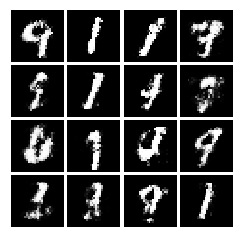

In [19]:
fig